In [ ]:
pip install yfinance

#### **API 키 설정**

#### **웹 검색과 코드 실행 도구 정의**

In [1]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)
python_repl_tool = PythonREPLTool()

#### **yfinance로 주어진 주식 종목에 대한 최근 주가 및 재무 분석 도구 정의**

In [2]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

ticker = yf.Ticker("NVDA")
historical_prices = ticker.history(period='5d', interval='1d')

last_5_days_close = historical_prices['Close'].tail(5)
last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}
# 연간 및 분기별 재무제표 데이터 가져오기
last_5_days_close_dict

{'2025-04-04': 94.30999755859375,
 '2025-04-07': 97.63999938964844,
 '2025-04-08': 96.30000305175781,
 '2025-04-09': 114.33000183105469,
 '2025-04-10': 107.56999969482422}

In [3]:
from langchain.tools import BaseTool, StructuredTool, tool
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

#재무 분석 툴 설정
@tool
def stock_analysis(ticker: str) -> str:
    """
    주어진 주식 티커에 대한 업데이트된 종합적인 재무 분석을 수행합니다.
    최신 주가 정보, 재무 지표, 성장률, 밸류에이션 및 주요 비율을 제공합니다.
    가장 최근 영업일 기준의 데이터를 사용합니다.
    
    :param ticker: 분석할 주식의 티커 심볼
    :return: 재무 분석 결과를 포함한 문자열
    """
    def format_number(number):
        if number is None or pd.isna(number):
            return "N/A"
        return f"{number:,.0f}"

    def format_financial_summary(financials):
        summary = {}
        for date, data in financials.items():
            date_str = date.strftime('%Y-%m-%d')
            summary[date_str] = {
                "총수익": format_number(data.get('TotalRevenue')),
                "영업이익": format_number(data.get('OperatingIncome')),
                "순이익": format_number(data.get('NetIncome')),
                "EBITDA": format_number(data.get('EBITDA')),
                "EPS(희석)": f"${data.get('DilutedEPS'):.2f}" if pd.notna(data.get('DilutedEPS')) else "N/A"
            }
        return summary

    ticker = yf.Ticker(ticker)
    historical_prices = ticker.history(period='5d', interval='1d')

    last_5_days_close = historical_prices['Close'].tail(5)
    last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}
    # 연간 및 분기별 재무제표 데이터 가져오기
    annual_financials = ticker.get_financials()
    quarterly_financials = ticker.get_financials(freq="quarterly")

    return str({
        "최근 5일간 종가": last_5_days_close_dict,
        "연간 재무제표 요약": format_financial_summary(annual_financials),
        "분기별 재무제표 요약": format_financial_summary(quarterly_financials),
    })

#### **Supervisor 에이전트 정의**

In [4]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Stock_Analyzer", "Chart_Generator"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members

class routeResponse(BaseModel):
    next: Literal[*options]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o-mini")

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

#### **하위 에이전트 정의 함수**

In [5]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

#### **하위 에이전트 설정**

In [6]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

research_system_prompt = """You are a helpful research analyst who is specialized in 
gathering valuable info for given stock."""
research_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier=research_system_prompt)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
stock_system_prompt="""You are a helpful Stock and financial analyst. Never hallucinate the given metrics."""
stock_agent = create_react_agent(llm, tools=[stock_analysis], state_modifier=stock_system_prompt)
stock_node = functools.partial(agent_node, agent=stock_agent, name="Stock_Analyzer")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
chart_system_prompt="""You are a helpful Stock Chart Generator. 
Only make accurate charts for given query. Chart design and accuracy should be state of the art.
Never make any other mention."""
chart_agent = create_react_agent(llm, tools=[python_repl_tool], state_modifier=chart_system_prompt)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart_Generator")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Stock_Analyzer", stock_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("supervisor", supervisor_agent)

In [7]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges(
    "supervisor", 
    lambda x: x["next"], 
    conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

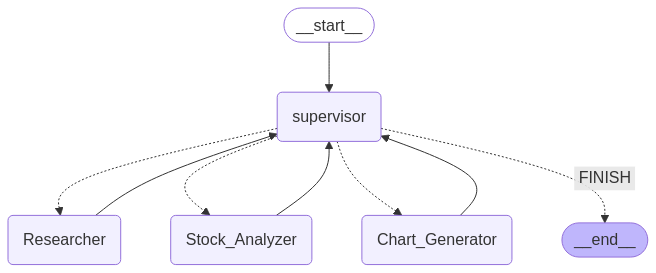

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='애플(AAPL) 주식 구매 결정을 위한 정보를 정리해드리겠습니다.\n\n### 1. 최근 주식 가격 및 성과\n- **현재 주가**: 2023년 10월 31일 기준 애플의 종가는 $169.53입니다. 한 달 간 0.3% 하락했습니다.\n- **과거 가격 변동**:\n  - 10월 초: 약 $172.49\n  - 10월 중순: 약 $177.55\n  - 10월 말: 약 $169.53\n- 다른 추천 가격 레벨:\n  - **저항선**: $197\n  - **지지선**: $166 (이 레벨 아래로 떨어지면 $155까지 하락할 가능성 있음)\n\n자세한 유적가격 흐름은 [StatMuse](https://www.statmuse.com/money/ask/apple-stock-price-in-october-2023)에서 확인 가능합니다.\n\n### 2. 주식 분석\n- 애플은 전통적으로 강력한 브랜드 파워와 안정된 수익 구조를 갖추고 있습니다.\n- 그러나 최근에는 무역 전쟁 및 다른 외부 요인들로 인해 주가 변동성이 커지고 있습니다.\n- 애널리스트들은 최근 애플의 목표 주가를 낮추었으며, 한 기관은 목표가를 $167.88로 하향 조정했습니다 ([TheStreet](https://www.thestreet.com/technology/analysts-rework-apple-stock-price-target-amid-tariff-troubles)).\n\n### 3. 배당금 및 재무 지표\n- **배당 수익률**: 0.43% (다음 배당금 지급일: 2025년 2월 12일)\n- **시가 총액**: 약 $3.21조\n- **P/E 비율**: 33.94배\n\n### 투자 결정을 위한 고려 사항\n- **장기 투자 시 초점**: 애플은 강력한 제품 라인업과 혁신을 바탕으로 장기적인 성장 잠재력을 가지고 있습니

Python REPL can execute arbitrary code. Use with caution.


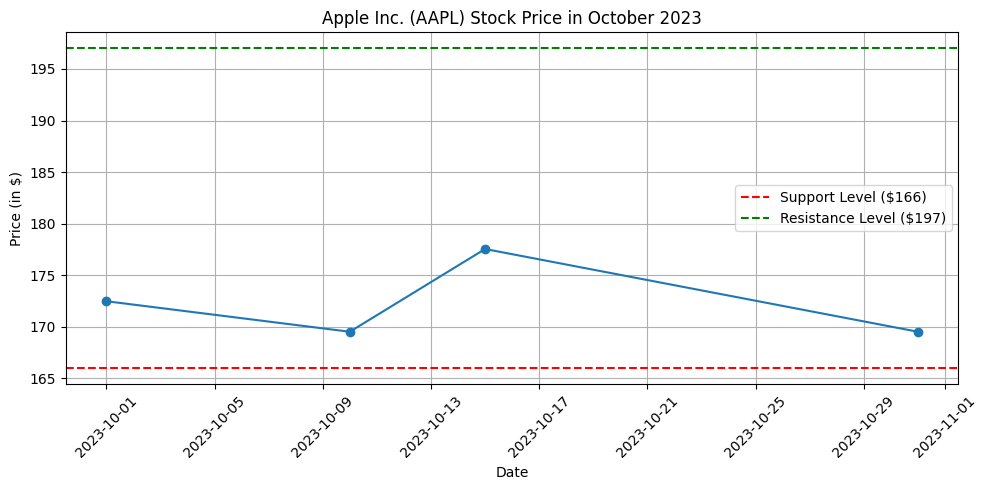

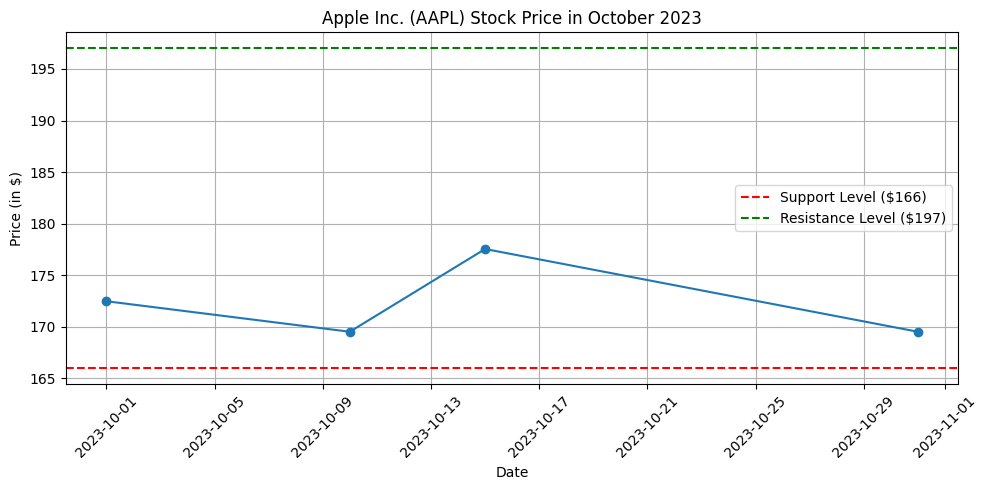

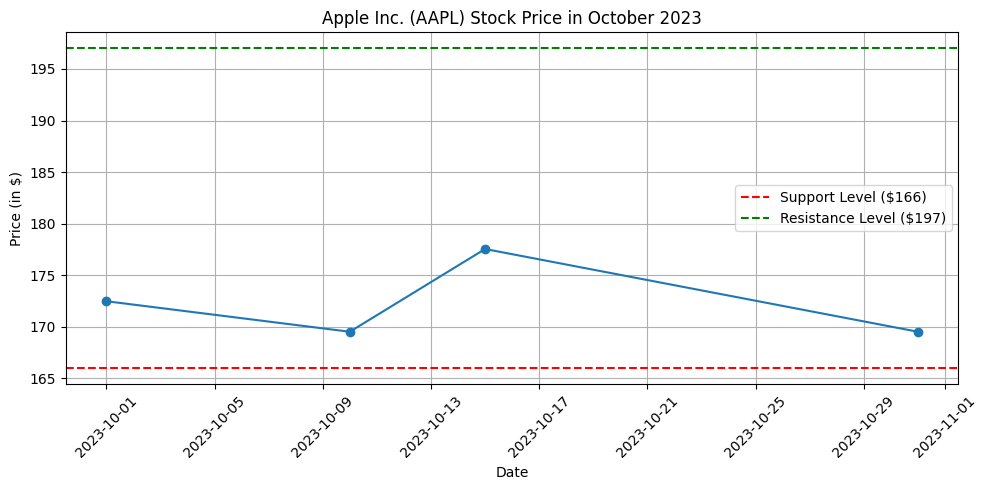

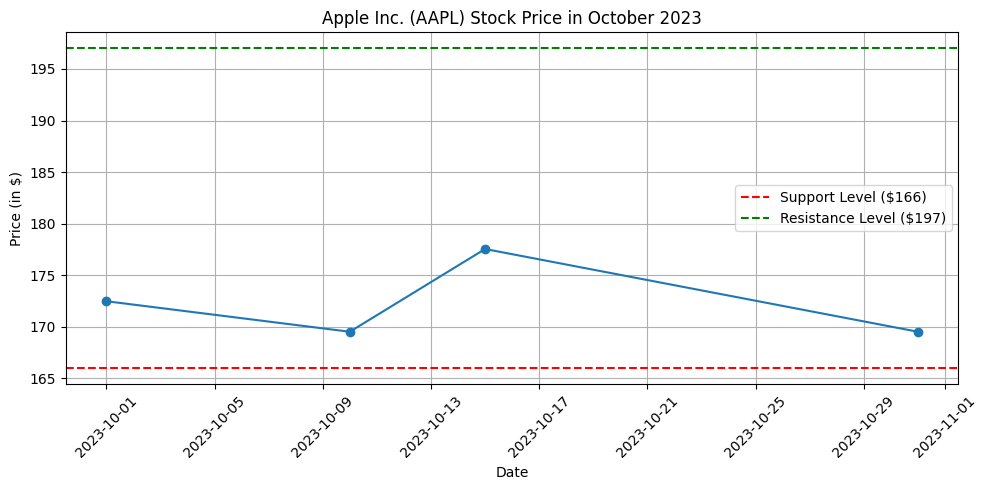

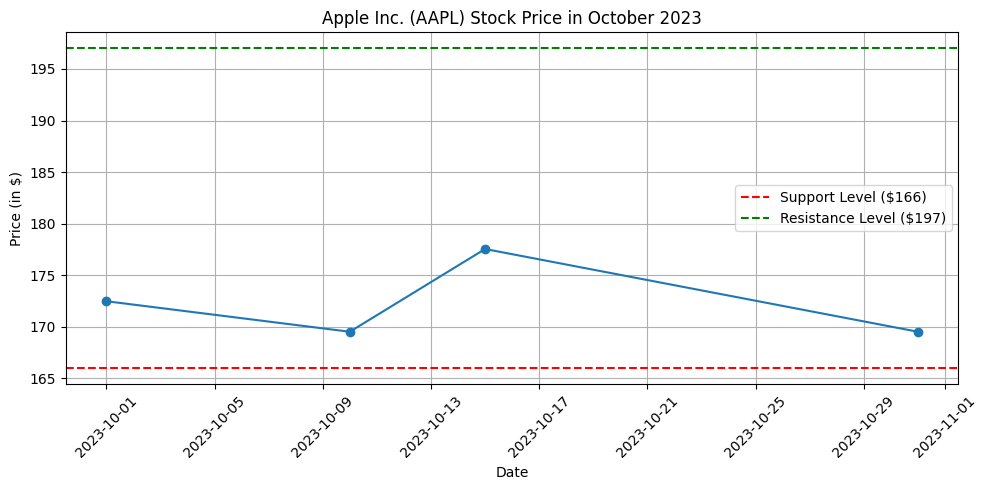

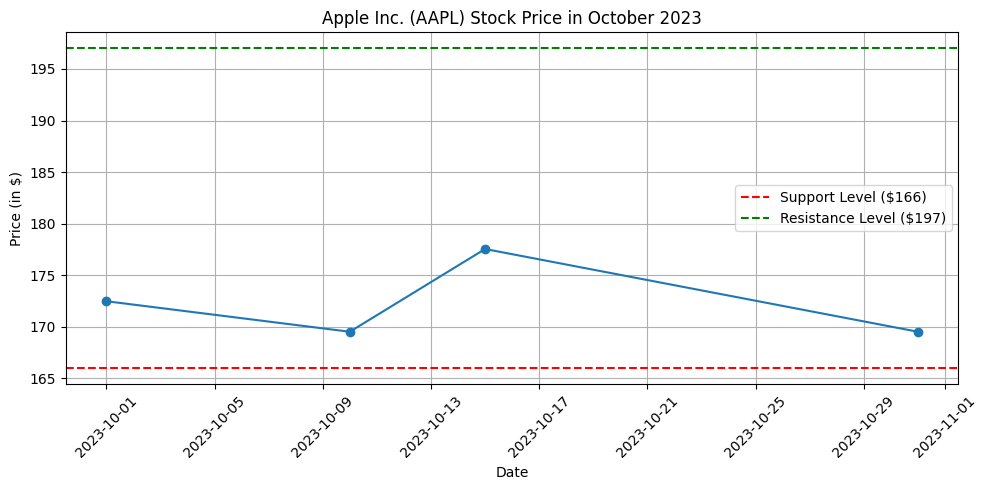

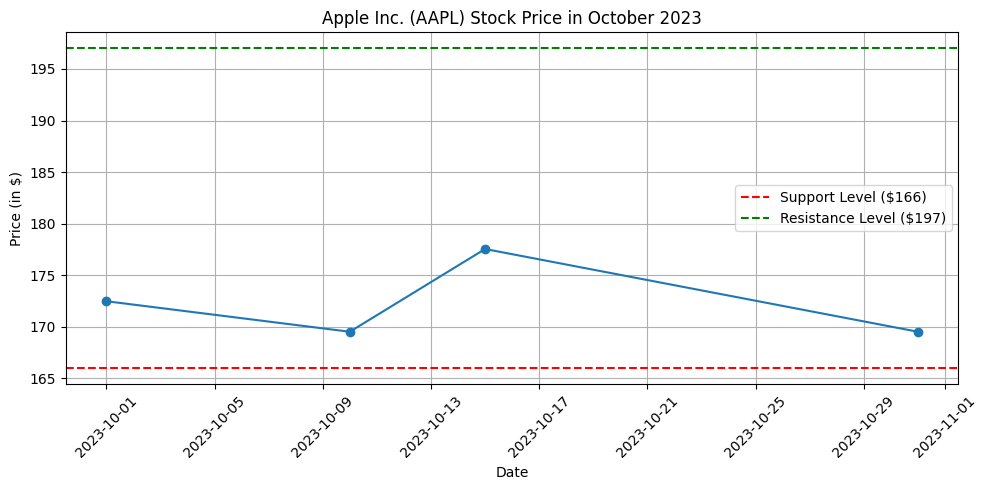

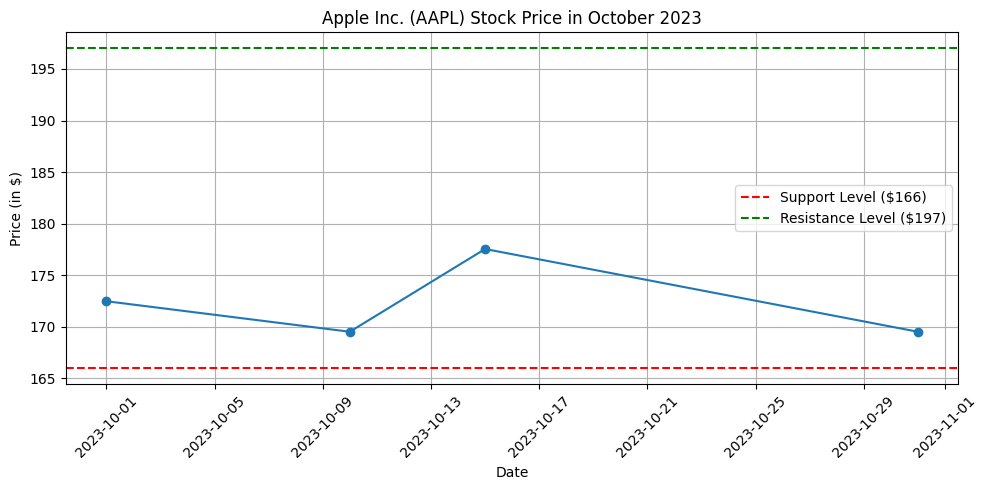

{'Chart_Generator': {'messages': [HumanMessage(content="Here's a chart depicting the stock price of Apple Inc. (AAPL) for October 2023, including support and resistance levels:\n\n![Apple Inc. (AAPL) Stock Price in October 2023](sandbox:/mnt/data/apple_stock_october_2023.png) \n\n- **Support Level:** $166 (indicated by a red dashed line)\n- **Resistance Level:** $197 (indicated by a green dashed line)\n\nThis chart shows the price movements throughout the month, providing a visual context for your investment decision.", additional_kwargs={}, response_metadata={}, name='Chart_Generator')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [9]:
for s in graph.stream({"messages": [HumanMessage(content="애플 주식 구매 의사 결정 도와줘")]}):
    if "__end__" not in s:
        print(s)
        print("----")